#Base Notebook

In [ ]:
#list of imports

#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#specific imports
from xgboost import XGBRegressor

#Sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose    import make_column_transformer, make_column_selector

from sklearn.metrics    import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression


In [68]:
#Loading data

data = pd.read_csv('/Users/rafael.hayashi/code/rafaeltshayashi/Forecasting-Gold-Price/raw_data/Extract_TimeFrame_60_clean.csv', sep=';')
data.head(10)

,time,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,Unnamed: 16
0,1/11/22 0:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677,NaN
1,1/11/22 1:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,NaN
2,1/11/22 2:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,NaN
3,1/11/22 3:00,1804.83,1806.31,1804.21,1805.18,1798.295,1806.31,1790.28,1795.105129,NaN,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677,NaN
4,1/11/22 4:00,1805.18,1807.73,1804.99,1805.91,1799.005,1807.73,1790.28,1796.398616,NaN,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677,NaN
5,1/11/22 5:00,1805.88,1806.73,1805.52,1806.72,1799.005,1807.73,1790.28,1796.796755,NaN,1797.136618,78.589560,0.909138,0.987403,2.519134,0.332677,NaN
6,1/11/22 6:00,1806.71,1808.63,1805.65,1808.41,1799.455,1808.63,1790.28,1797.850579,NaN,1797.752024,81.719853,0.936550,1.063483,2.519134,0.332677,NaN
7,1/11/22 7:00,1808.37,1809.79,1807.01,1808.22,1800.035,1809.79,1790.28,1799.205521,NaN,1798.448651,80.236144,0.876940,1.118710,2.519134,0.332677,NaN
8,1/11/22 8:00,1808.22,1809.74,1807.57,1809.18,1800.035,1809.79,1790.28,1799.728969,NaN,1799.305851,82.085020,0.876583,1.190612,2.519134,0.332677,NaN
9,1/11/22 9:00,1809.11,1810.16,1808.21,1808.82,1800.220,1810.16,1790.28,1800.566572,NaN,1799.996176,78.968473,0.825063,1.246739,2.495776,0.332677,NaN


<Axes: >

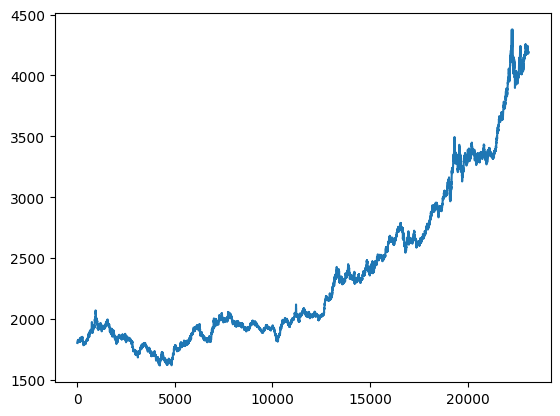

In [69]:
#Visual check

data['close'].plot()

In [186]:
#Features and target
X = data.drop(columns=['close','Up Trend','Down Trend','Unnamed: 16'])
X['time'] = pd.to_datetime(X['time'])
X['unix_timestamp'] = X['time'].apply(lambda x: x.timestamp())
X = X[1:]
y = data['close'].shift(1).dropna()

X.shape, y.shape


/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_77034/1818197618.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['time'] = pd.to_datetime(X['time'])


((23111, 14), (23111,))

In [187]:
#data check
X.dtypes.value_counts()

float64           13
datetime64[ns]     1
Name: count, dtype: int64

In [188]:
y.dtype

dtype('float64')

In [189]:
y.head(5)

1    1801.18
2    1802.70
3    1804.85
4    1805.18
5    1805.91
Name: close, dtype: float64

In [191]:
X.head(5)

,time,open,high,low,Basis,Upper,Lower,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,unix_timestamp
1,2022-01-11 01:00:00,1801.16,1804.61,1801.15,1797.445,1804.61,1790.28,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,1.641863e+09
2,2022-01-11 02:00:00,1802.68,1805.91,1802.00,1798.095,1805.91,1790.28,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,1.641866e+09
3,2022-01-11 03:00:00,1804.83,1806.31,1804.21,1798.295,1806.31,1790.28,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677,1.641870e+09
4,2022-01-11 04:00:00,1805.18,1807.73,1804.99,1799.005,1807.73,1790.28,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677,1.641874e+09
5,2022-01-11 05:00:00,1805.88,1806.73,1805.52,1799.005,1807.73,1790.28,1797.136618,78.589560,0.909138,0.987403,2.519134,0.332677,1.641877e+09


In [192]:
#preprocessing

preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    RobustScaler()
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, ['open', 'high', 'low', 'Basis', 'Upper', 'Lower', 'KAMA', 'RSI', 'Bollinger Bands %b', 'Bollinger BandWidth', 'Highest Expansion', 'Lowest Contraction','unix_timestamp']),
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['open', 'high', 'low', 'Basis', 'Upper',
                                  'Lower', 'KAMA', 'RSI', 'Bollinger Bands %b',
                                  'Bollinger BandWidth', 'Highest Expansion',
                                  'Lowest Contraction', 'unix_timestamp'])])

In [193]:
# Create eval test just for early-stopping purposes (XGBOOST and Deep Learning)
train_size = int(0.8 * len(X))
X_train, X_eval = X[:train_size], X[train_size:]
y_train, y_eval = y[:train_size], y[train_size:]


In [194]:
# Preprocess eval data
preproc_baseline.fit(X_train, y_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_eval_preproc = preproc_baseline.transform(X_eval)

In [195]:
X_train_preproc

array([[-0.33579243, -0.33258422, -0.33195834, ...,  0.04680314,
        -0.23891313, -0.99375658],
       [-0.33266236, -0.32991006, -0.33020522, ...,  0.04680314,
        -0.23891313, -0.99368398],
       [-0.32823496, -0.32908723, -0.32564711, ...,  0.04680314,
        -0.23891313, -0.99361138],
       ...,
       [ 1.89627532,  1.90462477,  1.89551408, ..., -0.27082227,
         1.25863057,  0.99869324],
       [ 1.90451234,  1.90513903,  1.86806229, ..., -0.27082227,
         1.25863057,  0.99876584],
       [ 1.87004041,  1.88487707,  1.87367227, ..., -0.27082227,
         1.25863057,  0.99883843]])

In [217]:
# Instantiate model
model_xgb = XGBRegressor(max_depth=2,
                         n_estimators=500,
                         learning_rate=0.3
                         )

In [218]:
# Train the model on a rolling window of data
for i in range(len(X_train_preproc) - 528):  # Use a 30-days rolling window
    X_window = X_train_preproc[i:i+528]
    y_window = y_train[i:i+528]
    model_xgb.fit(X_window, y_window)
    y_pred = model_xgb.predict(X_eval_preproc)
    mae = mean_absolute_error(y_eval, y_pred)
    print(f"MAE: {mae:.2f}")

MAE: 1651.26
MAE: 1651.65
MAE: 1651.17
MAE: 1651.46
MAE: 1651.50
MAE: 1650.76
MAE: 1651.66
MAE: 1651.40
MAE: 1651.19
MAE: 1651.50
MAE: 1651.84
MAE: 1651.06
MAE: 1651.47
MAE: 1650.94
MAE: 1651.28
MAE: 1651.02
MAE: 1651.25
MAE: 1651.17
MAE: 1651.49
MAE: 1646.88
MAE: 1644.33
MAE: 1643.31
MAE: 1642.87
MAE: 1642.70
MAE: 1642.96
MAE: 1642.80
MAE: 1642.25
MAE: 1642.61
MAE: 1642.84
MAE: 1642.13
MAE: 1642.24
MAE: 1642.96
MAE: 1642.94
MAE: 1642.74
MAE: 1642.91
MAE: 1642.45
MAE: 1643.01
MAE: 1643.48
MAE: 1637.23
MAE: 1635.61
MAE: 1635.72
MAE: 1635.55
MAE: 1632.10
MAE: 1632.15
MAE: 1631.43
MAE: 1630.79
MAE: 1631.68
MAE: 1631.05
MAE: 1631.09
MAE: 1627.32
MAE: 1625.47
MAE: 1625.65
MAE: 1625.62
MAE: 1624.63
MAE: 1624.85
MAE: 1624.57
MAE: 1626.92
MAE: 1625.22
MAE: 1625.46
MAE: 1624.66
MAE: 1624.86
MAE: 1624.79
MAE: 1625.52
MAE: 1623.58
MAE: 1623.47
MAE: 1624.00
MAE: 1624.30
MAE: 1623.01
MAE: 1623.42
MAE: 1624.23
MAE: 1624.82
MAE: 1624.62
MAE: 1624.44
MAE: 1624.60
MAE: 1624.54
MAE: 1625.37
MAE: 1625.05

KeyboardInterrupt: 

In [204]:
model_xgb2 = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=500,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

In [206]:
# Train the model on a rolling window of data. XGB2 model - specific parameters
for i in range(len(X_train_preproc) - 528):  # Use a 30-days rolling window
    X_window = X_train_preproc[i:i+528]
    y_window = y_train[i:i+528]
    model_xgb2.fit(X_window, y_window)
    y_pred = model_xgb2.predict(X_eval_preproc)
    mae = mean_absolute_error(y_eval, y_pred)
    print(f"MAE: {mae:.2f}")

MAE: 1650.97
MAE: 1651.10
MAE: 1651.04
MAE: 1651.12
MAE: 1651.05
MAE: 1651.02
MAE: 1651.08
MAE: 1651.09
MAE: 1651.22
MAE: 1651.13
MAE: 1651.03
MAE: 1651.03
MAE: 1651.04
MAE: 1651.09
MAE: 1651.07
MAE: 1651.08
MAE: 1651.00
MAE: 1651.01
MAE: 1651.28
MAE: 1645.79
MAE: 1644.20
MAE: 1642.27
MAE: 1642.48
MAE: 1642.23
MAE: 1642.40
MAE: 1642.59
MAE: 1642.35
MAE: 1642.51
MAE: 1642.48
MAE: 1642.50
MAE: 1642.45
MAE: 1642.36
MAE: 1642.12
MAE: 1642.18
MAE: 1642.24
MAE: 1642.12
MAE: 1642.53
MAE: 1641.55
MAE: 1636.69
MAE: 1634.94
MAE: 1635.10
MAE: 1635.69
MAE: 1632.09
MAE: 1632.21
MAE: 1631.19
MAE: 1630.99
MAE: 1631.21
MAE: 1631.16
MAE: 1631.13
MAE: 1626.84
MAE: 1625.69
MAE: 1625.69
MAE: 1625.28
MAE: 1624.44
MAE: 1624.41
MAE: 1624.41
MAE: 1624.41
MAE: 1624.43
MAE: 1624.49
MAE: 1624.46
MAE: 1624.49
MAE: 1624.37
MAE: 1624.44
MAE: 1624.47
MAE: 1624.48
MAE: 1624.49
MAE: 1624.49
MAE: 1624.37
MAE: 1624.49
MAE: 1624.51
MAE: 1624.53
MAE: 1624.46
MAE: 1624.49
MAE: 1624.36
MAE: 1624.45
MAE: 1624.43
MAE: 1624.49

KeyboardInterrupt: 

In [207]:
# Create a linear regression model
model_lr = LinearRegression()

# Train the model
model_lr.fit(X_train_preproc, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_eval_preproc)

# Calculate MAE
mae_lr = mean_absolute_error(y_eval, y_pred_lr)
print(f"MAE (Linear Regression): {mae_lr:.2f}")

MAE (Linear Regression): 0.17


In [215]:
pd.DataFrame(y_pred_lr).head()

,0
0,2872.356988
1,2877.492522
2,2883.259727
3,2887.322216
4,2879.229175


In [214]:
y_eval.head()

18489    2872.30
18490    2877.41
18491    2883.25
18492    2887.37
18493    2879.29
Name: close, dtype: float64

##Simplest Baseline for reference

In [216]:
y_pred_baseline = y_eval.shift(1).dropna()
y_true = y_eval[1:]
mae_baseline = mean_absolute_error(y_true, y_pred_baseline)
print(f"MAE (shift): {mae_baseline:.2f}")

MAE (shift): 6.10


In [211]:
# SARIMAX test

import pmdarima as pm
sarimax = pm.auto_arima(y_train, exogenous=X_train_preproc,
                           start_p=1, start_d=1,start_q=1,
                           test='adf',
                           max_p=3, max_d=2, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           D=None, trace=True,
                           suppress_warnings=True,
                           stepwise=False, n_jobs=-1,
                           random=True, random_state=42)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=102326.666, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=102328.050, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=102328.060, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=102328.674, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=102330.055, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=102328.747, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=102326.913, Time=1.40 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=102322.953, Time=1.62 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=102324.741, Time=1.80 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=102326.856, Time=2.02 sec

Best model:  ARIMA(2,1,1)(0,0,0)[1] intercept
Total fit time: 4.362 seconds


In [212]:
# Prediction
y_pred_sar = sarimax.predict(n_periods=len(y_eval), exogenous=X_eval_preproc)

# Calculate MAE

mae_sarimax = mean_absolute_error(y_eval, y_pred_sar)

print(f"MAE: {mae_sarimax:.2f}")

MAE: 496.64


/Users/rafael.hayashi/.pyenv/versions/3.10.6/envs/forecasting_gold_price/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rafael.hayashi/.pyenv/versions/3.10.6/envs/forecasting_gold_price/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [213]:
y_pred_sar.head(10)

18488    2872.557363
18489    2872.427175
18490    2872.649849
18491    2872.562954
18492    2872.748257
18493    2872.694226
18494    2872.850632
18495    2872.822008
18496    2872.956075
18497    2872.947094
dtype: float64